In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from pathlib import Path


In [3]:
# Paths
ROOT = Path.cwd().parent
DATA_DIR = ROOT / "data" / "processed" / "stage3_mlp_split"
MODEL_DIR = ROOT / "S3" / "model"
ARTIFACTS_DIR = ROOT / "S3"/ "artifacts"

MODEL_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [4]:
X_train = np.load(DATA_DIR / "X_train.npy")
X_val   = np.load(DATA_DIR / "X_val.npy")
X_test  = np.load(DATA_DIR / "X_test.npy")

y_train = np.load(DATA_DIR / "y_train.npy")   # encoded
y_val   = np.load(DATA_DIR / "y_val.npy")
y_test  = np.load(DATA_DIR / "y_test.npy")

y_test_original = np.load(DATA_DIR / "y_test_original.npy", allow_pickle=True)


In [5]:
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

print("Input dim:", input_dim)
print("Number of classes:", num_classes)


Input dim: 77
Number of classes: 26


In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

joblib.dump(scaler, ARTIFACTS_DIR / "scaler.pkl")


['C:\\Users\\DELL\\Desktop\\Network Intrusion Detection System\\S3\\artifacts\\scaler.pkl']

In [7]:
class Stage3MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [8]:
model = Stage3MLP(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [9]:
train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                  torch.tensor(y_train, dtype=torch.long)),
    batch_size=256, shuffle=True
)

val_loader = DataLoader(
    TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                  torch.tensor(y_val, dtype=torch.long)),
    batch_size=256, shuffle=False
)


In [10]:
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_loss = float("inf")

for epoch in range(30):
    # ---- Train ----
    model.train()
    correct = total = 0
    train_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        correct += (out.argmax(1) == yb).sum().item()
        total += yb.size(0)

    train_loss /= total
    train_acc = correct / total

    # ---- Validation ----
    model.eval()
    correct = total = 0
    val_loss = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)

            val_loss += loss.item() * xb.size(0)
            correct += (out.argmax(1) == yb).sum().item()
            total += yb.size(0)

    val_loss /= total
    val_acc = correct / total

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1:02d} | "
          f"Train Acc {train_acc:.4f} | Val Acc {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_DIR / "stage3_model.pth")


Epoch 01 | Train Acc 0.9948 | Val Acc 0.9987
Epoch 02 | Train Acc 0.9986 | Val Acc 0.9992
Epoch 03 | Train Acc 0.9989 | Val Acc 0.9992
Epoch 04 | Train Acc 0.9989 | Val Acc 0.9994
Epoch 05 | Train Acc 0.9990 | Val Acc 0.9994
Epoch 06 | Train Acc 0.9991 | Val Acc 0.9994
Epoch 07 | Train Acc 0.9991 | Val Acc 0.9994
Epoch 08 | Train Acc 0.9992 | Val Acc 0.9993
Epoch 09 | Train Acc 0.9992 | Val Acc 0.9994
Epoch 10 | Train Acc 0.9992 | Val Acc 0.9994
Epoch 11 | Train Acc 0.9992 | Val Acc 0.9995
Epoch 12 | Train Acc 0.9992 | Val Acc 0.9995
Epoch 13 | Train Acc 0.9993 | Val Acc 0.9994
Epoch 14 | Train Acc 0.9993 | Val Acc 0.9995
Epoch 15 | Train Acc 0.9993 | Val Acc 0.9995
Epoch 16 | Train Acc 0.9993 | Val Acc 0.9996
Epoch 17 | Train Acc 0.9993 | Val Acc 0.9995
Epoch 18 | Train Acc 0.9993 | Val Acc 0.9996
Epoch 19 | Train Acc 0.9993 | Val Acc 0.9993
Epoch 20 | Train Acc 0.9993 | Val Acc 0.9995
Epoch 21 | Train Acc 0.9994 | Val Acc 0.9995
Epoch 22 | Train Acc 0.9993 | Val Acc 0.9995
Epoch 23 |

In [11]:
model.load_state_dict(torch.load(MODEL_DIR / "stage3_model.pth"))
model.eval()

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    logits = model(X_test_t)
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    y_pred = logits.argmax(1).cpu().numpy()


C:\Users\DELL\Desktop\Productivity_FNN\Plastering_Productivity_FNN\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\DELL\Desktop\Productivity_FNN\Plastering_Productivity_FNN\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\DELL\Desktop\Productivity_FNN\Plastering_Productivity_FNN\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       769
           1       1.00      0.99      1.00       121
           2       0.95      0.95      0.95        22
           3       0.96      0.99      0.97       137
           4       0.99      0.98      0.99       170
           5       1.00      1.00      1.00     32452
           6       1.00      1.00      1.00     30242
           7       1.00      1.00      1.00     30194
           8       1.00      1.00      1.00     25149
           9       0.95      1.00      0.98      2854
          10       0.67      1.00      0.80         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00     31524
          13       1.00      1.00      1.00     37172
          14       1.00      1.00      1.00     29695
          15       1.00      1.00      1.00      8942
          16       1.00      1.00      1.00     31409
          17       1.00    

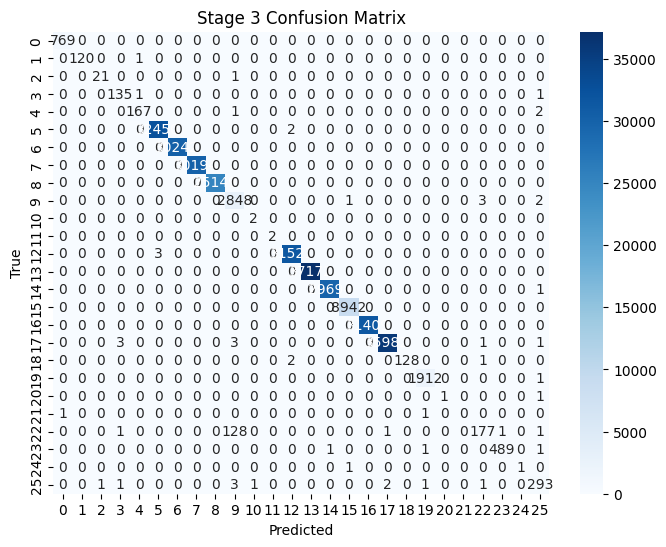

In [12]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Stage 3 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [13]:
with open(ARTIFACTS_DIR / "training_history.json", "w") as f:
    json.dump(history, f, indent=2)

print("✓ Stage 3 model and artifacts saved")


✓ Stage 3 model and artifacts saved


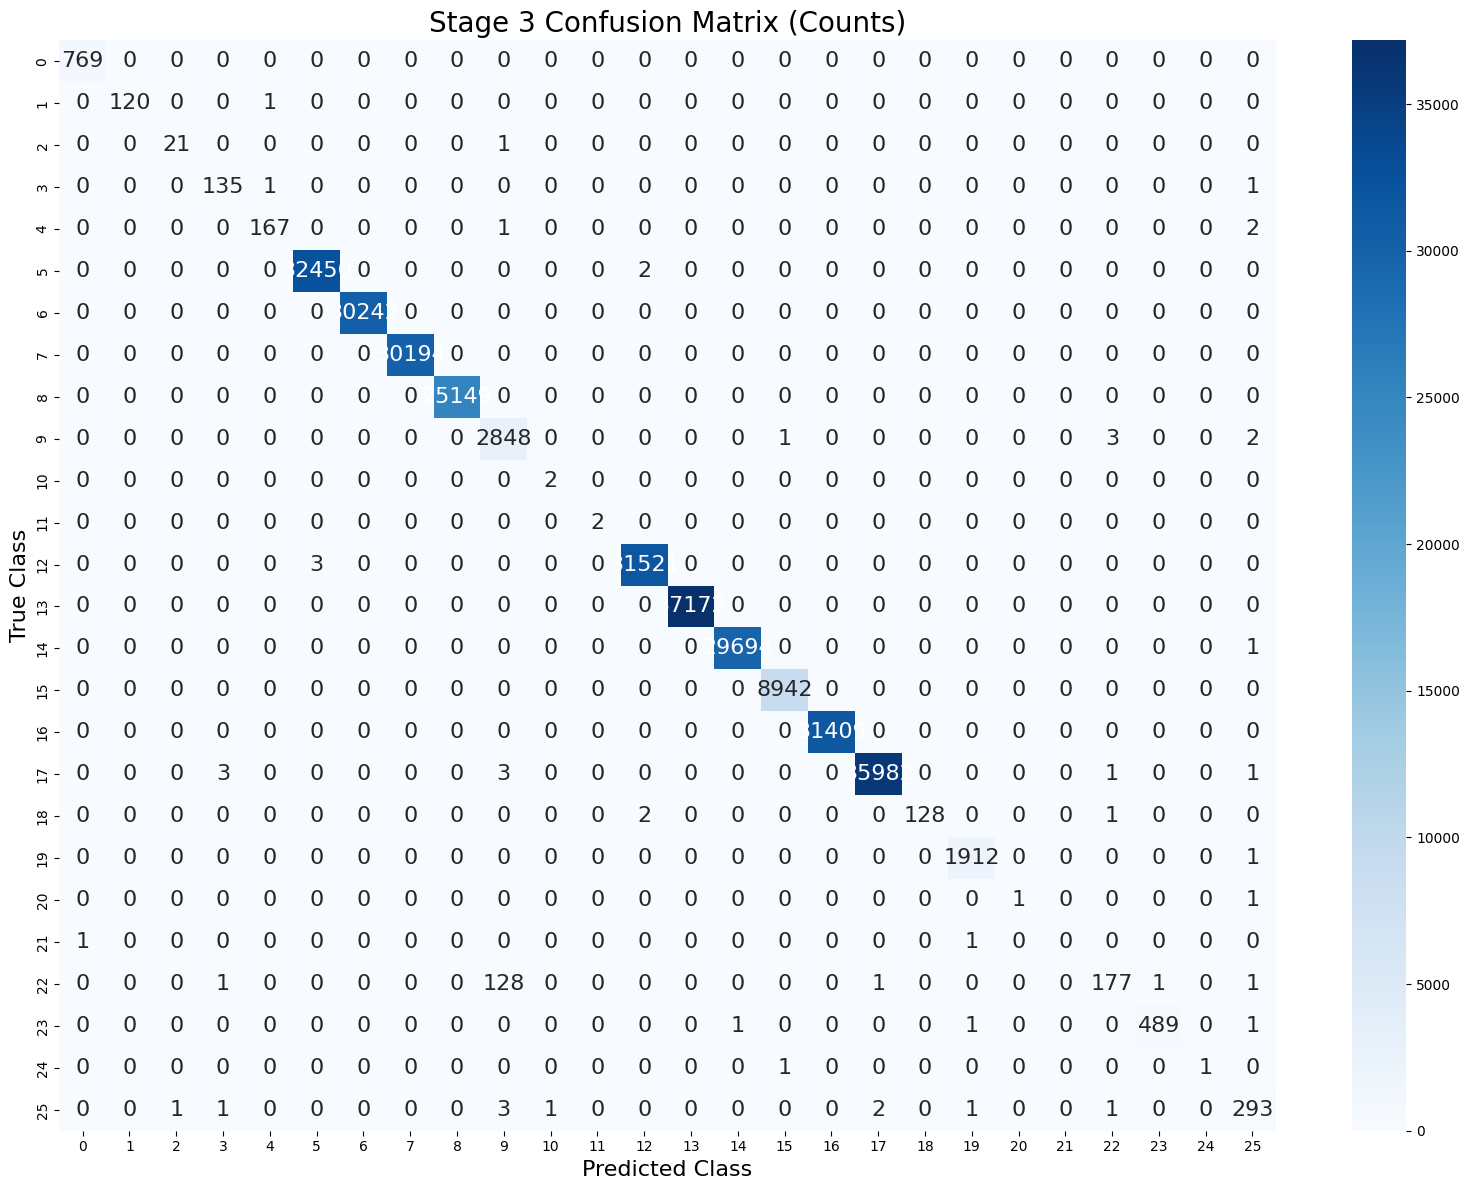

In [20]:
plt.figure(figsize=(16, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    annot_kws={"size": 16}
)

plt.title("Stage 3 Confusion Matrix (Counts)", fontsize=20)
plt.xlabel("Predicted Class", fontsize=16)
plt.ylabel("True Class", fontsize=16)

plt.tight_layout()
plt.show()


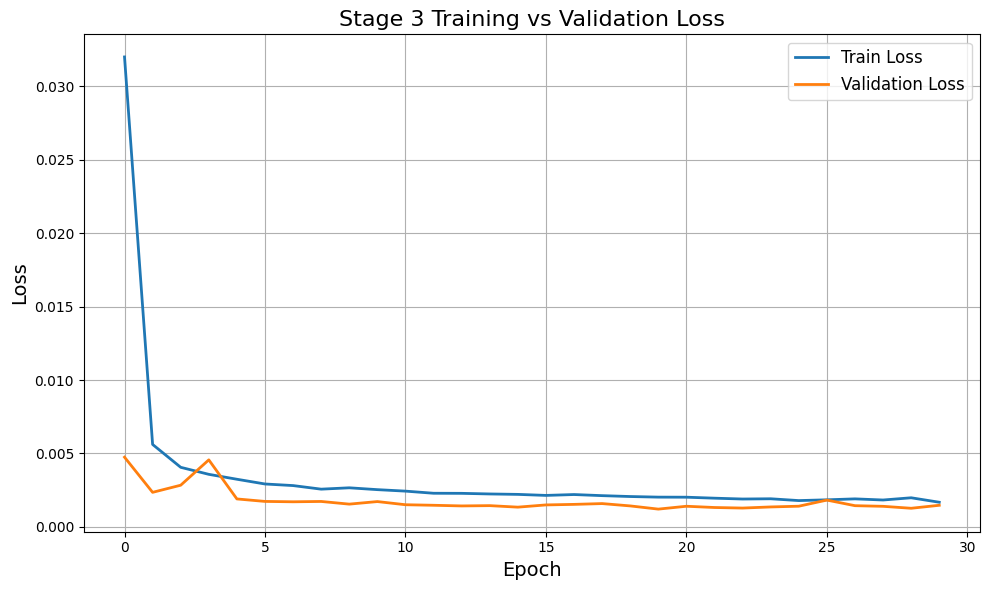

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)

plt.title('Stage 3 Training vs Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


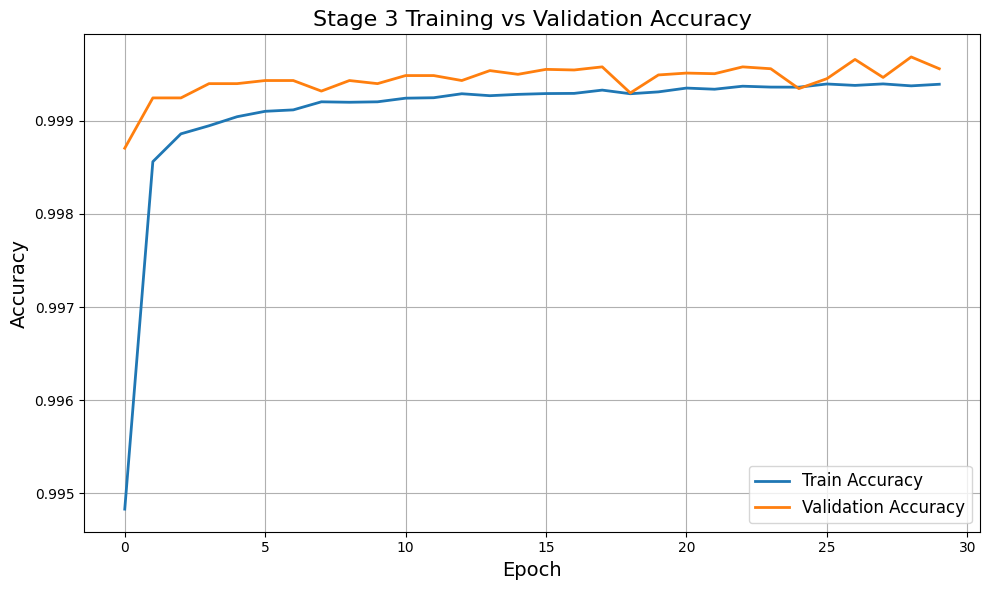

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
plt.plot(history['val_acc'], label='Validation Accuracy', linewidth=2)

plt.title('Stage 3 Training vs Validation Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()
